In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!unzip /content/drive/My\ Drive/Rovit\ Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Rovit Dataset/bounding_boxes/data_1/526_bbox_1.txt  
  inflating: Rovit Dataset/bounding_boxes/data_1/526_bbox_2.txt  
  inflating: Rovit Dataset/bounding_boxes/data_1/528_bbox_1.txt  
  inflating: Rovit Dataset/bounding_boxes/data_1/528_bbox_2.txt  
  inflating: Rovit Dataset/bounding_boxes/data_1/529_bbox_1.txt  
  inflating: Rovit Dataset/bounding_boxes/data_1/529_bbox_2.txt  
  inflating: Rovit Dataset/bounding_boxes/data_1/52_bbox_2.txt  
  inflating: Rovit Dataset/bounding_boxes/data_1/531_bbox_2.txt  
  inflating: Rovit Dataset/bounding_boxes/data_1/532_bbox_4.txt  
  inflating: Rovit Dataset/bounding_boxes/data_1/534_bbox_4.txt  
  inflating: Rovit Dataset/bounding_boxes/data_1/535_bbox_2.txt  
  inflating: Rovit Dataset/bounding_boxes/data_1/536_bbox_1.txt  
  inflating: Rovit Dataset/bounding_boxes/data_1/536_bbox_4.txt  
  inflating: Rovit Dataset/bounding_boxes/data_1/537_bbox_1.txt  
  inflating: Rovit Dataset

<h2><b>Data Preprocessing Part</b></h2>

In [0]:
import os
import re
import pickle
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [0]:
def joint_reader():
  """
  Read 2D Joints information.
  """
  joint_dict = {}
  data_dir = "/content/Rovit Dataset/projections_2d/data_1"

  with os.scandir(data_dir) as entries:
    for entry in entries:
      with open(os.path.join(data_dir, entry.name), "r") as f:
        joint_ar = np.zeros((0, 2))
        for line in f:
          _, x, y = line.split()
          joint_coordinate = np.array([[float(x), float(y)]])
          joint_ar = np.vstack((joint_ar, joint_coordinate))
        joint_dict["".join(re.findall("[0-9]+[_]*", entry.name))] = joint_ar

  return joint_dict

In [0]:
def bbox_reader():
  """
  Read bounding box information.
  """
  bounding_box_dict = {}
  data_dir = "/content/Rovit Dataset/bounding_boxes/data_1"

  with os.scandir(data_dir) as entries:
    for entry in entries:
      with open(os.path.join(data_dir, entry.name), "r") as f:
        bounding_box_dict["".join(re.findall("[0-9]+[_]*", entry.name))] = dict()
        for line in f:
          d_key, d_value = line.split()
          bounding_box_dict["".join(re.findall("[0-9]+[_]*", entry.name))][d_key] = np.array([[int(d_value)]])

  return bounding_box_dict

In [0]:
def image_reader():
  """
  Read image files.
  """
  image_dict = {}
  data_dir = "/content/Rovit Dataset/annotated_frames/data_1"

  with os.scandir(data_dir) as entries:
    for entry in entries:
      with open(os.path.join(data_dir, entry.name), "r") as f:
        if entry.name.endswith(".jpg"):
          image_dict["".join(re.findall("[0-9]+[_]*", entry.name))] = Image.open(os.path.join(data_dir, entry.name))
  
  return image_dict

In [0]:
def pickle_creator():
  """
  Create a pickled dataset.
  """
  pickle_dict = {"images": image_reader(),
                 "joints": joint_reader(),
                 "bounding_boxes": bbox_reader()}

  with open("dataset.pickle", "wb") as dataset:
    pickle.dump(pickle_dict, dataset)

In [0]:
pickle_creator()

In [0]:
# Read the data into a dictionary called dataset
dataset = {}
with open("dataset.pickle", "rb") as f:
  dataset = pickle.load(f, encoding="bytes")

In [0]:
def crop_images():
  """
  Crop the images in the dataset with the given bounding box information.
  Also, keep track of the greatest heights and widths so we can resize the
  images later.
  """
  max_width, max_height = 0, 0
  cropped_dict = dict()
  for im_name, im in dataset["images"].items():
    cropped_dict[im_name] = im.crop(
        (dataset["bounding_boxes"][im_name]["LEFT"][0, 0],
         dataset["bounding_boxes"][im_name]["TOP"][0, 0],
         dataset["bounding_boxes"][im_name]["RIGHT"][0, 0],
         dataset["bounding_boxes"][im_name]["BOTTOM"][0, 0])
        )
    
    if cropped_dict[im_name].width > max_width:
      max_width = cropped_dict[im_name].width
    if cropped_dict[im_name].height > max_height:
      max_height = cropped_dict[im_name].height

  return cropped_dict, max_width, max_height

In [0]:
cropped_images, max_width, max_height = crop_images()

In [0]:
padded_images = dict()

for im_name, im in cropped_images.items():
  h_pad = 400 - cropped_images[im_name].height
  w_pad = 400 - cropped_images[im_name].width
  # w_pad // 2 -> Left padding
  # h_pad // 2 -> Top padding
  padding = (w_pad // 2, h_pad // 2, w_pad - (w_pad // 2), h_pad - (h_pad // 2))
  padded_images[im_name] = ImageOps.expand(cropped_images[im_name], padding)

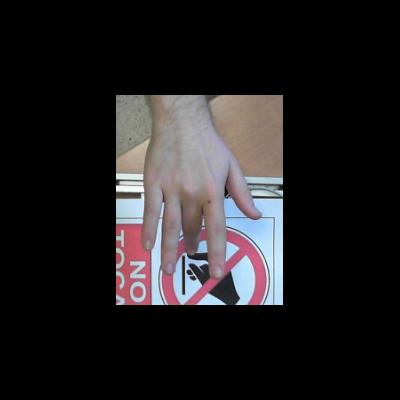

In [7]:
padded_images["623_3"] # An example image

In [8]:
dataset["joints"]

{'74_1': array([[308.09363752, 256.29530299],
        [353.53609329, 265.46030836],
        [280.19165562, 251.46885662],
        [259.31706701, 248.35005864],
        [296.06985493, 232.26023113],
        [349.33995805, 244.16830495],
        [262.04877565, 226.44065045],
        [238.44183581, 223.39714971],
        [316.47172598, 204.26162843],
        [353.1925132 , 217.33596703],
        [294.89775788, 199.17537552],
        [275.25064458, 196.37234944],
        [299.1929292 , 224.04824904],
        [351.21692374, 227.32066744],
        [266.78127593, 226.51273412],
        [245.41517485, 230.45915612],
        [394.80765721, 299.86879726],
        [433.08090414, 283.45085842],
        [362.13842321, 310.01540171],
        [341.83571264, 319.71632036],
        [372.88035867, 250.11635929]]),
 '282_1': array([[287.5776916 , 192.3407444 ],
        [336.20235253, 200.20740393],
        [257.53870268, 191.5340671 ],
        [235.40735546, 193.32785049],
        [281.37514576, 163.5972

In [0]:
# Rearrange joint coordinates

for im_name, joints in dataset["joints"].items():
  bounding_box = dataset["bounding_boxes"][im_name]
  h_pad = 400 - cropped_images[im_name].height
  w_pad = 400 - cropped_images[im_name].width
  subt = np.array([[bounding_box["LEFT"][0, 0] - (w_pad // 2), bounding_box["TOP"][0, 0] - (h_pad // 2)]])
  joints -= subt

In [0]:
def show_joints(image_name, landmarks=None):

    """
    Show image with joints marked. Code adapted from https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    """

    image = padded_images[image_name]
    plt.imshow(image, aspect="auto")
    if landmarks is None:
      landmarks = dataset["joints"][image_name]
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)

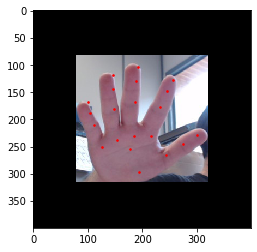

In [11]:
plt.figure()
show_joints("707_4")
plt.show()

<h2><b>Deep Learning</b></h2>

In [0]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.utils.data

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
class MultiViewHandposeDataset(Dataset):

  def __init__(self, padded_images, joints):
    self.joints = joints
    self.images = list()
    for im_name, im in padded_images.items():
      self.images.append((im_name, torch.tensor(np.asarray(im), dtype=torch.double).permute(2, 0, 1)))
    
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx][1]
    joints = self.joints[self.images[idx][0]]

    sample = {"image_name": self.images[idx][0],
              "image": image,
              "joints": joints.flatten()}

    return sample

In [0]:
hand_dataset = MultiViewHandposeDataset(padded_images, dataset["joints"])

In [0]:
num_epochs = 100
num_outputs = 42
batch_size = 16
learning_rate = 0.001
validation_split = .1

In [0]:
train_dataset, validation_dataset = torch.utils.data.random_split(hand_dataset,
                                                                  (int(len(hand_dataset) * validation_split),
                                                                  len(hand_dataset) - int(len(hand_dataset) * validation_split)))

In [0]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [62]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['joints'].size())
    
    break

0 torch.Size([16, 3, 400, 400]) torch.Size([16, 42])


In [0]:
model = torchvision.models.resnet18(pretrained=True).float()

In [0]:
model.fc = nn.Linear(in_features=512, out_features=42, bias=True)

In [0]:
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [129]:
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, sample in enumerate(train_loader):
        images = sample["image"].to(device)
        labels = sample["joints"].to(device)
        
        # Forward pass
        outputs = model(images.float())
        loss = criterion(outputs.double(), labels.double())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/100], Step [2/18], Loss: 45.9713
Epoch [1/100], Step [4/18], Loss: 48.6417
Epoch [1/100], Step [6/18], Loss: 48.8694
Epoch [1/100], Step [8/18], Loss: 38.7661
Epoch [1/100], Step [10/18], Loss: 76.0336
Epoch [1/100], Step [12/18], Loss: 55.3524
Epoch [1/100], Step [14/18], Loss: 50.6954
Epoch [1/100], Step [16/18], Loss: 40.4685
Epoch [1/100], Step [18/18], Loss: 59.5140
Epoch [2/100], Step [2/18], Loss: 61.0671
Epoch [2/100], Step [4/18], Loss: 58.8370
Epoch [2/100], Step [6/18], Loss: 107.5934
Epoch [2/100], Step [8/18], Loss: 45.9634
Epoch [2/100], Step [10/18], Loss: 48.8428
Epoch [2/100], Step [12/18], Loss: 34.9133
Epoch [2/100], Step [14/18], Loss: 43.5085
Epoch [2/100], Step [16/18], Loss: 59.2369
Epoch [2/100], Step [18/18], Loss: 70.4211
Epoch [3/100], Step [2/18], Loss: 41.5292
Epoch [3/100], Step [4/18], Loss: 89.2355
Epoch [3/100], Step [6/18], Loss: 71.1507
Epoch [3/100], Step [8/18], Loss: 49.2028
Epoch [3/100], Step [10/18], Loss: 41.9118
Epoch [3/100], Step [1

In [0]:
model.eval()
predicted_joints = list()
with torch.no_grad():
    for sample in validation_loader:
        prediction = model(sample["image"].to(device).float())
        for i, image_name in enumerate(sample["image_name"]):
          predicted_joints.append((image_name, prediction[i, :]))

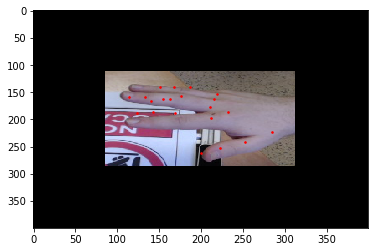

In [182]:
show_joints(predicted_joints[144][0], predicted_joints[144][1].cpu().numpy().reshape(21, 2))

In [0]:
torch.save(model.state_dict(), 'model400epoch.ckpt')

<h2><b>Original Photo Experiment</b></h2>

In [0]:
image = Image.open("/content/drive/My Drive/el2.jpg").resize((400, 400))

In [0]:
image_tensor = torch.from_numpy(np.asarray(image)).permute(2, 0, 1)

In [0]:
original_sample = {"image_name": "original", "image": torch.unsqueeze(image_tensor, 0)}

In [0]:
model.eval()
preds = None
with torch.no_grad():
      preds = model(original_sample["image"].to(device).float())

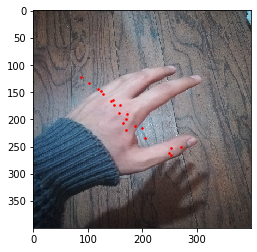

In [195]:
plt.imshow(image)
landmarks = preds.cpu().numpy().reshape(21, 2)
plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
plt.pause(0.001)

I mean, I can't say it works well outside the dataset.